## 1. Import Libraries

In [ ]:
# !pip3 install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## 2. Load Data

In [3]:
file_path = 'C:\AIT\FirstSem\CP\Project\CDR-Call-Details.csv'
df = pd.read_csv(file_path)
df_copy = df

## 3. Feature Engineering

In [4]:
df['total_mins'] = df['Day Mins'] + df['Eve Mins'] + df['Night Mins'] + df['Intl Mins']
df['total_call'] = df['Day Calls'] + df['Eve Calls'] + df['Night Calls'] + df['Intl Calls']

df['mins_per_call'] = df['total_mins']/df['total_call']

## 4. Train Test Split

In [4]:
df.head()

,Phone Number,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn,total_mins,total_call,mins_per_call
0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,717.2,303,2.366997
1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,625.2,332,1.883133
2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,539.4,333,1.619820
3,375-9999,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,564.8,255,2.214902
4,330-6626,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,512.0,359,1.426184


In [5]:
X = df.drop(columns = ['Phone Number','Day Charge','Eve Charge','Night Charge','Intl Charge','Churn'], axis = 'columns')
le = LabelEncoder()
y = le.fit_transform(df['Churn'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=df['Churn'])

In [7]:
X_train.dtypes

Account Length      int64
VMail Message       int64
Day Mins          float64
Day Calls           int64
Eve Mins          float64
Eve Calls           int64
Night Mins        float64
Night Calls         int64
Intl Mins         float64
Intl Calls          int64
CustServ Calls      int64
total_mins        float64
total_call          int64
mins_per_call     float64
dtype: object

In [8]:
X_train.isna().sum()

Account Length    0
VMail Message     0
Day Mins          0
Day Calls         0
Eve Mins          0
Eve Calls         0
Night Mins        0
Night Calls       0
Intl Mins         0
Intl Calls        0
CustServ Calls    0
total_mins        0
total_call        0
mins_per_call     0
dtype: int64

## Scaling

In [7]:
std_scalar = StandardScaler()
X_train = std_scalar.fit_transform(X_train)
X_test  = std_scalar.transform(X_test)

## 5. Model

In [8]:
class ChurnPredictionEnsemble(object):
    def __init__(self):
        self.lr  = LogisticRegression()
        self.knn = KNeighborsClassifier()
        self.rf  = RandomForestClassifier()
        self.gb  = GradientBoostingClassifier()
        self.xgb  = xgb.XGBClassifier()
        
    def fit(self, X_train, y_train):
        kfold = 5
        # scoring = {'accuracy': make_scorer(accuracy_score),'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

        lr_param_grid = {
            # best param
            # 'C': [0.001],
            # 'penalty': ['l2'],
            # 'solver': ['lbfgs']
            
            'solver': ['lbfgs'], # , 'liblinear'
            'penalty': ['l2','none'], # , 'elasticnet', 'None',
            'C': [0.1, 0.01, 0.001]
        }
        self.lr_grid = GridSearchCV(estimator = self.lr, param_grid = lr_param_grid, cv = kfold, n_jobs = -1, return_train_score=True, refit=True, scoring='accuracy')
        self.lr_grid.fit(X_train, y_train)
        
        knn_param_grid = {
            'n_neighbors': [1,3,5], #
            'weights': ['uniform', 'distance'], # ['uniform', 'distance'],
            'metric': ['euclidean'] # 'euclidean', 'manhattan', 'minkowski'
        }
        self.knn_grid = GridSearchCV(estimator=self.knn, param_grid=knn_param_grid, cv=kfold, return_train_score=True, refit=True, scoring='accuracy', n_jobs=-1)
        self.knn_grid.fit(X_train, y_train)
        
        rf_param_grid = {
            'n_estimators': [10, 100],
            'max_features': ['sqrt', 'log2']
        }
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        self.rf_grid = GridSearchCV(estimator=self.rf, param_grid=rf_param_grid, cv=cv, return_train_score=True, refit=True, scoring='accuracy', n_jobs=-1)
        self.rf_grid.fit(X_train, y_train)
        
        gb_para_grid = {
            # best params
            'learning_rate': [0.01],
            'loss':['exponential'],
            'max_depth':[1],
            'max_features':['log2'],
            'min_samples_leaf': [0.1],
            'min_samples_split': [0.1],
            'subsample':[0.5],
            'n_estimators':[5]
            
            # 'learning_rate': [0.01, 0.001, 0.0001],
            # 'loss':['exponential', 'log_loss'],
            # 'min_samples_split': np.linspace(0.1, 0.5), # , 12
            # 'min_samples_leaf': np.linspace(0.1, 0.5),  # , 12
            # 'max_depth':[1,3],
            # 'max_features':['log2'], # 'log2','sqrt'
            # # 'criterion': ['friedman_mse', 'mae'],
            # 'subsample':[0.5, 1.0], # 0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0
            # 'n_estimators':[5]
        }
        self.gb_grid = GridSearchCV(estimator=self.gb, param_grid=gb_para_grid, cv=kfold, return_train_score=True, refit=True, scoring='accuracy', n_jobs=-1)
        self.gb_grid.fit(X_train, y_train)
        
        xgb_param_grid = {
            # best params
            'learning_rate': [0.1],
            'max_depth': [10],
            'n_estimators': [180],
            'random_state': [42]
            
            # 'max_depth': [3, 5, 10], # range (2, 10, 1),
            # 'n_estimators': range(60, 220, 40),
            # 'random_state' : [42],
            # 'learning_rate': [0.1, 0.01, 0.05]
        }
        self.xgb_grid = GridSearchCV(estimator=self.xgb, param_grid=xgb_param_grid, cv=kfold, return_train_score=True, refit=True, scoring='accuracy', n_jobs=-1)
        self.xgb_grid.fit(X_train, y_train)
    
    def generate_predictions(self,x):
        predictions = []
        
        predictions.append(self.lr_grid.predict(x))
        predictions.append(self.knn_grid.predict(x))
        predictions.append(self.rf_grid.predict(x))
        predictions.append(self.gb_grid.predict(x))
        predictions.append(self.xgb_grid.predict(x))
        
        return np.array(predictions)
    
    def calculate_average_prediction(self, predictions_list):
        return np.mean(predictions_list, axis=0)
    
    def final_churn_classification(self, transformed_prediction):
        threshold = 0.5
        return np.where(transformed_prediction >= threshold, 1, 0)
    
    def predict_churn(self, X):
        model_predictions = self.generate_predictions(X)
        average_prediction = self.calculate_average_prediction(model_predictions)
        final_classification = self.final_churn_classification(average_prediction)
        return final_classification

## Validation

In [9]:
predict_churn = ChurnPredictionEnsemble()
predict_churn.fit(X_train, y_train)

In [10]:
y_hat = predict_churn.predict_churn(X_train)

In [11]:
y_hat_df = pd.DataFrame(y_hat, columns=['Churn'])
ratio = y_hat_df['Churn'].value_counts()
print(ratio)

0    61024
1     6762
Name: Churn, dtype: int64


### Best Parameters for each Model

In [ ]:
# predict_churn.lr_grid.best_params_
# {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}

# predict_churn.knn_grid.best_params_
# {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

# predict_churn.rf_grid.best_params_
# {'max_features': 'sqrt', 'n_estimators': 100}

# predict_churn.gb_grid.best_params_
# {'learning_rate': 0.01,
#  'loss': 'exponential',
#  'max_depth': 1,
#  'max_features': 'log2',
#  'min_samples_leaf': 0.1,
#  'min_samples_split': 0.1,
#  'n_estimators': 5,
#  'subsample': 0.5}

predict_churn.xgb_grid.best_params_
# {'learning_rate': 0.1,
#  'max_depth': 10,
#  'n_estimators': 180,
#  'random_state': 42}

### Training Score

In [12]:
print(f"Accuracy  : {(accuracy_score(y_train, y_hat)):.2f}")
print(f"Precision : {(precision_score(y_train, y_hat)):.2f}")
print(f"Recall    : {(recall_score(y_train, y_hat)):.2f}")
print(f"F1_Score  : {(f1_score(y_train, y_hat)):.2f}")

# print classification report
print(classification_report(y_train, y_hat))

Accuracy  : 0.98
Precision : 0.91
Recall    : 0.87
F1_Score  : 0.89
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     60730
           1       0.91      0.87      0.89      7056

    accuracy                           0.98     67786
   macro avg       0.95      0.93      0.94     67786
weighted avg       0.98      0.98      0.98     67786



### Training Confusion Matrix

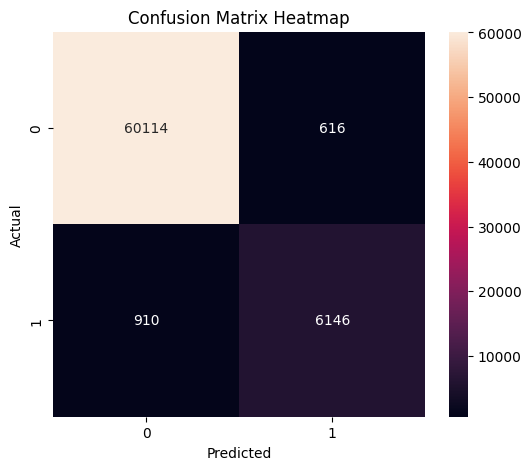

In [13]:
#display confusion matrix
cm = confusion_matrix(y_train, y_hat)
cmp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

### Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

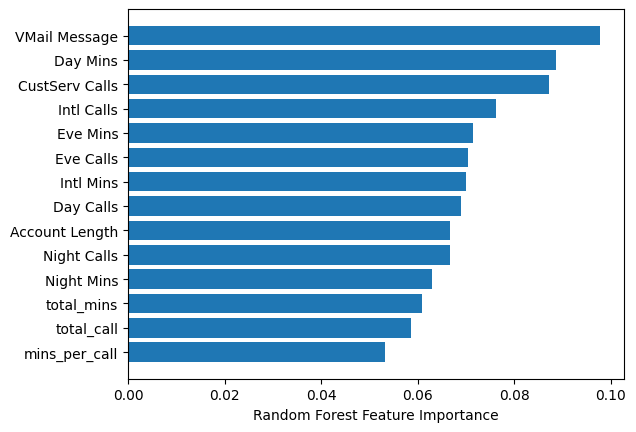

In [14]:
# Retrieve feature importance scores
best_xgb = predict_churn.xgb_grid.best_estimator_
feature_importances = best_xgb.feature_importances_

sorted_idx = feature_importances.argsort()
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Testing

In [15]:
y_pred = predict_churn.predict_churn(X_test)

In [16]:
print(f"Accuracy  : {(accuracy_score(y_test, y_pred)):.2f}")
print(f"Precision : {(precision_score(y_test, y_pred)):.2f}")
print(f"Recall    : {(recall_score(y_test, y_pred)):.2f}")
print(f"F1_Score  : {(f1_score(y_test, y_pred)):.2f}")

# print classification report
print(classification_report(y_test, y_pred))

Accuracy  : 0.96
Precision : 0.87
Recall    : 0.73
F1_Score  : 0.80
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29912
           1       0.87      0.73      0.80      3476

    accuracy                           0.96     33388
   macro avg       0.92      0.86      0.89     33388
weighted avg       0.96      0.96      0.96     33388



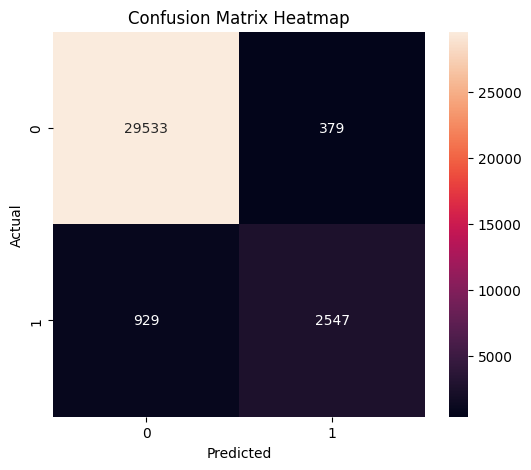

In [17]:
#display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [18]:
lr_yhat = predict_churn.lr_grid.predict(X_test)
knn_yhat = predict_churn.knn_grid.predict(X_test)
rf_yhat = predict_churn.rf_grid.predict(X_test)
gb_yhat = predict_churn.gb_grid.predict(X_test)
xgb_yhat = predict_churn.xgb_grid.predict(X_test)

In [19]:
print(f"Lr_Accuracy  : {(accuracy_score(y_test, lr_yhat)):.2f}")
print(f"Lr_F1_Score  : {(f1_score(y_test, lr_yhat)):.2f}")
print("Lr Classification Report")
print(classification_report(y_test, lr_yhat))
print("------------------------------------------------------------")
print(f"KNN_Accuracy  : {(accuracy_score(y_test, knn_yhat)):.2f}")
print(f"KNN_F1_Score  : {(f1_score(y_test, knn_yhat)):.2f}")
print("KNN Classification Report")
print(classification_report(y_test, knn_yhat))
print("------------------------------------------------------------")
print(f"RF_Accuracy  : {(accuracy_score(y_test, rf_yhat)):.2f}")
print(f"RF_F1_Score  : {(f1_score(y_test, rf_yhat)):.2f}")
print("RF Classification Report")
print(classification_report(y_test, rf_yhat))
print("------------------------------------------------------------")
print(f"GB_Accuracy  : {(accuracy_score(y_test, gb_yhat)):.2f}")
print(f"GB_F1_Score  : {(f1_score(y_test, gb_yhat)):.2f}")
print("GB Classification Report")
print(classification_report(y_test, gb_yhat))
print("------------------------------------------------------------")
print(f"XGB_Accuracy  : {(accuracy_score(y_test, xgb_yhat)):.2f}")
print(f"XGB_F1_Score  : {(f1_score(y_test, xgb_yhat)):.2f}")
print("XGB Classification Report")
print(classification_report(y_test, xgb_yhat))

Lr_Accuracy  : 0.90
Lr_F1_Score  : 0.00
Lr Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     29912
           1       0.00      0.00      0.00      3476

    accuracy                           0.90     33388
   macro avg       0.45      0.50      0.47     33388
weighted avg       0.80      0.90      0.85     33388

------------------------------------------------------------
KNN_Accuracy  : 0.96
KNN_F1_Score  : 0.81
KNN Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29912
           1       0.84      0.79      0.81      3476

    accuracy                           0.96     33388
   macro avg       0.91      0.88      0.90     33388
weighted avg       0.96      0.96      0.96     33388

------------------------------------------------------------
RF_Accuracy  : 0.96
RF_F1_Score  : 0.82
RF Classification Report
              precision   

C:\Users\putoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\putoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\putoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29912
           1       0.86      0.76      0.81      3476

    accuracy                           0.96     33388
   macro avg       0.92      0.87      0.89     33388
weighted avg       0.96      0.96      0.96     33388



In [20]:
import pickle

In [21]:
filename = 'C:/AIT/FirstSem/CP/Project/CDC_ChurnPrediction.pkl'

In [22]:
pickle.dump(predict_churn, open(filename,'wb+'))

In [23]:
model = pickle.load(open(filename,'rb+'))

In [24]:
yhat_2 = model.predict_churn(X_test)

In [16]:
print(f"Accuracy  : {(accuracy_score(y_test, yhat_2)):.2f}")
print(f"Precision : {(precision_score(y_test, yhat_2)):.2f}")
print(f"Recall    : {(recall_score(y_test, yhat_2)):.2f}")
print(f"F1_Score  : {(f1_score(y_test, yhat_2)):.2f}")

# print classification report
print(classification_report(y_test, yhat_2))

Accuracy  : 0.96
Precision : 0.87
Recall    : 0.73
F1_Score  : 0.80
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     29912
           1       0.87      0.73      0.80      3476

    accuracy                           0.96     33388
   macro avg       0.92      0.86      0.89     33388
weighted avg       0.96      0.96      0.96     33388

